# import packages

In [633]:
from itertools import permutations, product

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score, f1_score, recall_score, precision_score, brier_score_loss, average_precision_score, classification_report, log_loss
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

from sklearn.neural_network import MLPClassifier
from collections import Counter
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import numpy as np
from numpy import mean,std
from sklearn.model_selection import GridSearchCV

import pickle

from ctgan import CTGANSynthesizer
from mlxtend.classifier import StackingCVClassifier

from os import path
import tqdm
import matplotlib.pyplot as plt

from warnings import simplefilter
from collections import OrderedDict
from sklearn.svm import SVC

if (os.path.abspath('').split('/')[-1] == 'project'):
    %cd utils
elif (os.path.abspath('').split('/')[-1] == 'train_and_vis'):
    %cd ../utils

import query_utils
import model_utils
import validation_utils
import data_utils

if (os.path.abspath('').split('/')[-1] == 'utils'):
    %cd ..


simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

/Users/benjaminli/Documents/coding/scires/project/utils
/Users/benjaminli/Documents/coding/scires/project


### Synthetic Data creation
Performed with CTGANSynthesizer

In [2]:
isZoonotic = df.loc[df['isZoonotic']==1][:1200]
isZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(isZoonotic)

posGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
posGanModel.fit(isZoonotic)

# check if current model is better than pickled model
posGanModel.save('models/curr_models/posGanModel.pkl')

notZoonotic = df.loc[df['isZoonotic']==0][:3000]
notZoonotic = isZoonotic.loc[:, isZoonotic.columns != 'isZoonotic']
print(notZoonotic)

negGanModel = CTGANSynthesizer(batch_size=60, epochs=10, verbose=True)
negGanModel.fit(notZoonotic)
negGanModel.save('models/curr_models/negGanModel.pkl')

NameError: name 'df' is not defined

# Dataset retrieval
Workings of the function is packaged into data_utils (for readability). Data is generated within "process_data.ipynb".

In [2]:
dataset = data_utils.retrieveMerged(dir='data/')
# datasets = data_utils.retrieveAllDatasets()

working directory: /Users/benjaminli/Documents/coding/scires/project


In [849]:
print(len(dataset['f2-4']['X']))
print(len(dataset['f2-4']['y'])-sum(dataset['f2-4']['y']))

10627
9085


## Keep track of scores of each model

In [23]:
# modelScores = {}
import json
modelScores = pickle.load(open('score_df.pkl', 'rb'))
modelScores = modelScores.T.to_dict()
modelScores

score_df = pickle.load(open('score_df.pkl', 'rb'))

# TODO

### Generate & validate performance of KNN (baseline) on dataset

In [4]:
print(dataset.keys())

dict_keys(['f1-3', 'f2-3', 'f3-3', 'f1-4', 'f2-4', 'f3-4', 'f1-5', 'f2-5', 'f3-5', 'f1-6', 'f2-6', 'f3-6'])


In [14]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = -1), n_estimators = 1, n_jobs = -1)

        # knntest = KNeighborsClassifier(n_neighbors = 1, n_jobs = -1)
        knntest.fit(X_train, y_train)
        # print(knntest.score(X_test, y_test))
        x = cross_validate(knntest, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])
        
        name = f'knn_{feature}_{kmer}'
        
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
            print('already in modelScores')

fit_time 0.006434345245361328
score_time 0.23126916885375975
test_recall 0.8065397385785735
test_f1 0.601296422615953
test_accuracy 0.8332461512921254
test_precision 0.48886637902036434
test_roc_auc 0.8221471395149335
test_neg_brier_score -0.1667538487078745
fit_time 0.006704187393188477
score_time 0.07589864730834961
test_recall 0.8065502458706343
test_f1 0.5710774429523003
test_accuracy 0.8175344806596204
test_precision 0.4473588072765174
test_roc_auc 0.8129614190277772
test_neg_brier_score -0.1824655193403796
fit_time 0.006073999404907227
score_time 0.03609743118286133
test_recall 0.8169524650107174
test_f1 0.6050472649993741
test_accuracy 0.8296698577831887
test_precision 0.4922435812769397
test_roc_auc 0.8243815709753642
test_neg_brier_score -0.17033014221681148
fit_time 0.02127671241760254
score_time 0.34290475845336915
test_recall 0.8065292312865127
test_f1 0.5827334292475597
test_accuracy 0.820355265342261
test_precision 0.4651860242243905
test_roc_auc 0.8146019849332949
test_n

In [17]:
print(modelScores)

{'knn_f1_4': {'fit_time': 0.556103515625, 'score_time': 2.1676071643829347, 'test_recall': 0.8967847686294288, 'test_f1': 0.5506206040204477, 'test_accuracy': 0.7598422223451939, 'test_precision': 0.4068609142945686, 'test_roc_auc': 0.8166917789212086, 'test_neg_brier_score': -0.24015777765480606}, 'knn_f2_4': {'fit_time': 0.5469307899475098, 'score_time': 0.5283036708831788, 'test_recall': 0.7209095112007733, 'test_f1': 0.49014203521664257, 'test_accuracy': 0.7846974710862709, 'test_precision': 0.37431163097253817, 'test_roc_auc': 0.7581982888970294, 'test_neg_brier_score': -0.2153025289137292}, 'knn_f3_4': {'fit_time': 0.5275906562805176, 'score_time': 0.5401241779327393, 'test_recall': 0.8695246501071743, 'test_f1': 0.5344595291629525, 'test_accuracy': 0.7597513806651541, 'test_precision': 0.39288153362735134, 'test_roc_auc': 0.8053181863634385, 'test_neg_brier_score': -0.24024861933484587}}


### Evaluate & validate performance of random forest (baseline) on dataset

In [15]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        randforest = BalancedRandomForestClassifier(max_features="sqrt", n_jobs=-1)

        # randforest.fit(X_train, y_train)
        randforest.fit(X_train, y_train)
        x = cross_validate(randforest, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])
        name = f'rf_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')


fit_time 0.673237657546997
score_time 0.06305813789367676
test_recall 0.8033287101248267
test_f1 0.6376446981126623
test_accuracy 0.8496201427701843
test_precision 0.557841501561644
test_roc_auc 0.9113908529679753
test_neg_brier_score -0.1036142534713076
fit_time 0.30217394828796384
score_time 0.038896369934082034
test_recall 0.7734417685873997
test_f1 0.6213791860135606
test_accuracy 0.8658125394278124
test_precision 0.5325331554110591
test_roc_auc 0.9063302693213835
test_neg_brier_score -0.1044856117846273
fit_time 0.28589487075805664
score_time 0.03607010841369629
test_recall 0.8026772580170638
test_f1 0.635436790839013
test_accuracy 0.8511267777101434
test_precision 0.5558658633147152
test_roc_auc 0.9113416202038491
test_neg_brier_score -0.10388738292291518
fit_time 0.3828004837036133
score_time 0.04037809371948242
test_recall 0.8247236582188038
test_f1 0.6207048310771551
test_accuracy 0.83861386752255
test_precision 0.5229388200064958
test_roc_auc 0.910494420772485
test_neg_brier_

### XGB classifier

In [16]:
kmer = 4

features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        xgb1 = BalancedBaggingClassifier(base_estimator=XGBClassifier(
        learning_rate =0.1,
        n_estimators=300,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
        ), n_estimators=1, n_jobs=-1)
        xgb1.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(xgb1, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])
        name = f'xgb_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

fit_time 3.2481399536132813
score_time 0.015207624435424805
test_recall 0.8098222166183332
test_f1 0.5993580116185406
test_accuracy 0.8287332411045322
test_precision 0.49247938747250075
test_roc_auc 0.8983555937573016
test_neg_brier_score -0.13648852807028594
fit_time 3.682933235168457
score_time 0.01545543670654297
test_recall 0.7974509309460764
test_f1 0.5985745962711088
test_accuracy 0.8438875546455649
test_precision 0.48785963453151826
test_roc_auc 0.8971440087235623
test_neg_brier_score -0.12304992852125171
fit_time 3.7060344219207764
score_time 0.014565849304199218
test_recall 0.8137288278064977
test_f1 0.6115900124135841
test_accuracy 0.834283083393282
test_precision 0.5106685846240002
test_roc_auc 0.9068828343370023
test_neg_brier_score -0.1307657871800653
fit_time 3.781730365753174
score_time 0.01956338882446289
test_recall 0.8156201403774219
test_f1 0.6104394394548548
test_accuracy 0.8383293010901444
test_precision 0.5084032815414197
test_roc_auc 0.9124100464192155
test_neg_b

In [10]:
print(modelScores.keys())

dict_keys(['rf_f1_3', 'rf_f2_3', 'rf_f3_3', 'rf_f1_4', 'rf_f2_4', 'rf_f3_4', 'rf_f1_5', 'rf_f2_5', 'rf_f3_5', 'rf_f1_6', 'rf_f2_6', 'rf_f3_6', 'xgb_f1_3', 'xgb_f2_3', 'xgb_f3_3', 'xgb_f1_4', 'xgb_f2_4', 'xgb_f3_4', 'xgb_f1_5', 'xgb_f2_5', 'xgb_f3_5', 'xgb_f1_6', 'xgb_f2_6', 'xgb_f3_6'])


In [17]:
# ds = datasets['merged']['lengthdivdataset-4']
features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        mlp = BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6, hidden_layer_sizes=(100, 180, 180, 200, 200),
              max_iter=550, random_state=42, solver='adam', activation='relu'), n_estimators=5, n_jobs=-1)
        mlp.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(mlp, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision']])
        name = f'mlp_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

fit_time 5.641985559463501
score_time 0.3429579257965088
test_recall 0.7909805404951037
test_f1 0.6129231538456255
test_accuracy 0.8570628299485363
test_precision 0.5071047997117664
test_roc_auc 0.915887930020903
test_neg_brier_score -0.10401978874103301
fit_time 12.340601348876953
score_time 0.29123740196228026
test_recall 0.7689047198755936
test_f1 0.6527537339157734
test_accuracy 0.8850068728902662
test_precision 0.5774773243160104
test_roc_auc 0.9211042043255068
test_neg_brier_score -0.08127809550056461
fit_time 12.69257574081421
score_time 0.34751105308532715
test_recall 0.8383453116462825
test_f1 0.6473697885556842
test_accuracy 0.8494335011897516
test_precision 0.5495825398084325
test_roc_auc 0.9188979100863088
test_neg_brier_score -0.10668787556757205
fit_time 9.182259464263916
score_time 0.38588614463806153
test_recall 0.8072016979783971
test_f1 0.6601338755726636
test_accuracy 0.8749357534170772
test_precision 0.5686347080784393
test_roc_auc 0.9236435213170576
test_neg_brier_

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


fit_time 32.21785717010498
score_time 0.711247444152832
test_recall 0.7974656411549615
test_f1 0.6316306377024214
test_accuracy 0.8657188644789995
test_precision 0.5371231872472746
test_roc_auc 0.9202469133832045
test_neg_brier_score -0.09866557396511037
fit_time 24.688657188415526
score_time 0.6551656723022461
test_recall 0.8007102929433026
test_f1 0.6163852010676341
test_accuracy 0.84877941453157
test_precision 0.5110844203436183
test_roc_auc 0.9071307607457563
test_neg_brier_score -0.11622677904897338


In [ ]:
fit_time 71.89677076339721
score_time 0.10850300788879394
test_recall 0.8584950773558369
test_f1 0.6911281484361098
test_accuracy 0.8864734363076601
test_precision 0.5796959595204415
test_roc_auc 0.9540192015137766
test_neg_brier_score -0.07964541647825815

In [20]:
print(len(modelScores.keys()))
# print(modelScores.keys())
# print(modelScores['mlp_balanced_normalized_4'])
# print(modelScores['mlp_balanced_normalized_4'])

48


In [21]:
features = ['f1', 'f2', 'f3']
for kmer in range(3, 7):
    for feature in features:
        ds = dataset[f'{feature}-{kmer}']

        X, y = ds['X'], ds['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
        temp_svm = BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42, max_iter=500), n_estimators=1, n_jobs=-1)
        temp_svm.fit(X_train, y_train)

        # randforest.fit(X_train, y_train)
        x = cross_validate(temp_svm, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])
        name = f'svm_{feature}_{kmer}'
        if (name not in modelScores):
            modelScores[name] = {}
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
        else:
            for k, v in x.items():
                print(k, v.mean())
                modelScores[name][k]=v.mean()
            print('already in modelScores')

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 1.9005918025970459
score_time 1.832925271987915
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.510706523502875
test_neg_brier_score -0.14527397592299335
fit_time 1.0388792037963868
score_time 1.184439754486084
test_recall 0.7682637750598916
test_f1 0.6470785392118301
test_accuracy 0.8794546843008135
test_precision 0.5694617314417644
test_roc_auc 0.9059787336109665
test_neg_brier_score -0.08563907097963931
fit_time 1.820357084274292
score_time 1.633793306350708
test_recall 0.6223111839616695
test_f1 0.6622677588722691
test_accuracy 0.9047616623319129
test_precision 0.7670728169863373
test_roc_auc 0.8690880648935909
test_neg_brier_score -0.07928686951563617


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 6.530042266845703
score_time 3.4427698135375975
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.5082480131965573
test_neg_brier_score -0.1457355230836727
fit_time 6.441674995422363
score_time 3.110650157928467
test_recall 0.7195666792754171
test_f1 0.680627734884343
test_accuracy 0.9109778982900781
test_precision 0.6755043001874332
test_roc_auc 0.9195314656792288
test_neg_brier_score -0.06779188285595661
fit_time 4.718837118148803
score_time 2.7102776527404786
test_recall 0.7358361703021898
test_f1 0.6401249173404641
test_accuracy 0.877006253112722
test_precision 0.5891997818295154
test_roc_auc 0.8913670041328989
test_neg_brier_score -0.08740740861294846


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 31.155922889709473
score_time 12.689632606506347
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.5064696334864541
test_neg_brier_score -0.14603576232779042
fit_time 31.866920471191406
score_time 12.23724298477173
test_recall 0.3319232547387887
test_f1 0.44129358607854174
test_accuracy 0.8936664047368712
test_precision 0.8403621359124871
test_roc_auc 0.875871270787408
test_neg_brier_score -0.0972674594534371
fit_time 25.571607255935668
score_time 10.544783449172973
test_recall 0.7461669398562603
test_f1 0.5291742991048717
test_accuracy 0.8215867190526257
test_precision 0.4163185110362675
test_roc_auc 0.8431971153418008
test_neg_brier_score -0.13201217769586973


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


fit_time 109.18032379150391
score_time 53.78303756713867
test_recall 0.0012965998402891608
test_f1 0.002584820962522184
test_accuracy 0.8550861380111782
test_precision 0.4
test_roc_auc 0.50618518657562
test_neg_brier_score -0.146554394177546
fit_time 101.62899775505066
score_time 47.86398730278015
test_recall 0.1095553313999916
test_f1 0.18371642419827017
test_accuracy 0.8666605279176581
test_precision 0.8303641312939307
test_roc_auc 0.8119340753412974
test_neg_brier_score -0.12238631828837598
fit_time 109.11372156143189
score_time 50.53300194740295
test_recall 0.8898226369100156
test_f1 0.3489018698900065
test_accuracy 0.49279548447789273
test_precision 0.21956569655117636
test_roc_auc 0.7556959434635748
test_neg_brier_score -0.2238242948240226


In [11]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb1_test = XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

xgb1_test.fit(X_train, y_train, eval_metric='aucpr', eval_set=[(X_validation, y_validation)], early_stopping_rounds=10, verbose=10)
# xgb1.fit(X_train, y_train)

# x = cross_validate(xgb1, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'])

# for k, v in x.items():
#         print(k, v.mean())
        # modelScores[name][k]=v.mean()

# X_test = X_test[xgb1.get_booster().feature_names]

[0]	validation_0-aucpr:0.61638
[10]	validation_0-aucpr:0.80782
[20]	validation_0-aucpr:0.82789
[30]	validation_0-aucpr:0.84020
[40]	validation_0-aucpr:0.84760
[50]	validation_0-aucpr:0.85234
[60]	validation_0-aucpr:0.85953
[70]	validation_0-aucpr:0.86429
[80]	validation_0-aucpr:0.86687
[90]	validation_0-aucpr:0.87223
[100]	validation_0-aucpr:0.87421
[110]	validation_0-aucpr:0.87528
[120]	validation_0-aucpr:0.87590
[130]	validation_0-aucpr:0.87729
[140]	validation_0-aucpr:0.87882
[150]	validation_0-aucpr:0.87985
[160]	validation_0-aucpr:0.88051
[170]	validation_0-aucpr:0.88118
[180]	validation_0-aucpr:0.88190
[188]	validation_0-aucpr:0.88187


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [21]:
x = cross_validate(xgb1, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])
print(x)

{'fit_time': array([10.12263608,  9.00429296,  9.30413198, 11.99384427, 11.84370995,
       10.79316092, 10.00633025, 10.09028506, 11.25545502, 10.31688499]), 'score_time': array([0.01476312, 0.01359987, 0.01377797, 0.0210948 , 0.01741576,
       0.0173142 , 0.01482892, 0.01795101, 0.01406169, 0.01382995]), 'test_recall': array([0.90967742, 0.79354839, 0.91558442, 0.92207792, 0.99350649,
       0.64935065, 0.44805195, 0.48051948, 0.12987013, 0.15584416]), 'test_f1': array([0.84939759, 0.83959044, 0.8952381 , 0.91612903, 0.96226415,
       0.72463768, 0.59227468, 0.63247863, 0.20512821, 0.21238938]), 'test_accuracy': array([0.95296331, 0.95578551, 0.96895579, 0.97554092, 0.98871119,
       0.92850423, 0.91063029, 0.91902072, 0.85404896, 0.83239171]), 'test_precision': array([0.79661017, 0.89130435, 0.8757764 , 0.91025641, 0.93292683,
       0.81967213, 0.87341772, 0.925     , 0.48780488, 0.33333333]), 'test_roc_auc': array([0.9871323 , 0.97677277, 0.97996943, 0.99192776, 0.99757833,
   

In [15]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train random forest
randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
randforest.fit(X_train, y_train)

# train svm
temp_svm = BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42), n_estimators=1, n_jobs=-1)
temp_svm.fit(X_train, y_train)

# train knn
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1, n_jobs=-1), n_estimators=1, n_jobs=-1)
knn.fit(X_train, y_train)


BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=-1,
                                                              n_neighbors=1),
                          n_estimators=1, n_jobs=-1)

In [12]:
pickle.dump(xgb1_test, open('models/curr_models/xgBoost-f2-4-2.pkl', 'wb'))

In [20]:
# assess each model
xgb1 = pickle.load(open('models/curr_models/xgBoost-f2-4-2.pkl', 'rb'))

models = [randforest, temp_svm, knn, xgb1]
modelNames = ['randforest', 'svm', 'knn', 'xgboost']
for i in range(len(models)):
    model = models[i]
    modelName = modelNames[i]
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(f'{modelName} recall: \n{recall_score(y_test, y_pred)}')
    print(f'{modelName} f1: \n{f1_score(y_test, y_pred)}')
    print(f'{modelName} accuracy: \n{accuracy_score(y_test, y_pred)}')
    print(f'{modelName} precision: \n{precision_score(y_test, y_pred)}')
    print(f'{modelName} roc_auc: \n{roc_auc_score(y_test, y_pred_proba)}')
    print(f'{modelName} brier_score: \n{brier_score_loss(y_test, y_pred_proba)}')
    print(f'{modelName} confusion matrix: \n{confusion_matrix(y_test, y_pred).ravel()}')
    print(f'{modelName} classification report: \n{classification_report(y_test, y_pred)}')
    print(f'{modelName} roc_curve: \n{roc_curve(y_test, y_pred_proba)}')
    print(f'{modelName} precision_recall_curve: \n{precision_recall_curve(y_test, y_pred_proba)}')
    print(f'{modelName} average_precision_score: \n{average_precision_score(y_test, y_pred_proba)}')

randforest recall: 
0.7254901960784313
randforest f1: 
0.5144843568945539
randforest accuracy: 
0.8029162746942615
randforest precision: 
0.3985637342908438
randforest roc_auc: 
0.7707121310062487
randforest brier_score: 
0.19708372530573848
randforest confusion matrix: 
[1485  335   84  222]
randforest classification report: 
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1820
           1       0.40      0.73      0.51       306

    accuracy                           0.80      2126
   macro avg       0.67      0.77      0.70      2126
weighted avg       0.87      0.80      0.82      2126

randforest roc_curve: 
(array([0.        , 0.18406593, 1.        ]), array([0.       , 0.7254902, 1.       ]), array([2., 1., 0.]))
randforest precision_recall_curve: 
(array([0.14393227, 0.39856373, 1.        ]), array([1.       , 0.7254902, 0.       ]), array([0., 1.]))
randforest average_precision_score: 
0.328664900178798
svm recall: 
0.7

In [31]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
mlp = BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6, hidden_layer_sizes=(100, 180, 180, 200, 200),
              max_iter=550, random_state=42, solver='adam', activation='relu'), n_estimators=5, n_jobs=-1)
mlp.fit(X_train, y_train)

# randforest.fit(X_train, y_train)
x = cross_validate(mlp, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])

BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6,
                                                       hidden_layer_sizes=(100,
                                                                           180,
                                                                           180,
                                                                           200,
                                                                           200),
                                                       max_iter=550,
                                                       random_state=42),
                          n_estimators=5, n_jobs=-1)

In [32]:
for k, v in x.items():
        print(k, v.mean())
        # modelScores[name][k]=v.mean()
pickle.dump(mlp, open('models/curr_models/mlp-f2-4.pkl', 'wb'))

fit_time 12.1881685256958
score_time 0.3574349880218506
test_recall 0.7935716387172697
test_f1 0.6657728990542772
test_accuracy 0.8810549056499364
test_precision 0.5883703167135279
test_roc_auc 0.9227783079806313
test_neg_brier_score -0.08561184605431278
test_average_precision 0.7611865843305569


0.7617328519855596
0.049377249726187136
0.9577982475041299
0.6895424836601307
0.8626687296053343
0.8628240575084943
0.47541095284633406


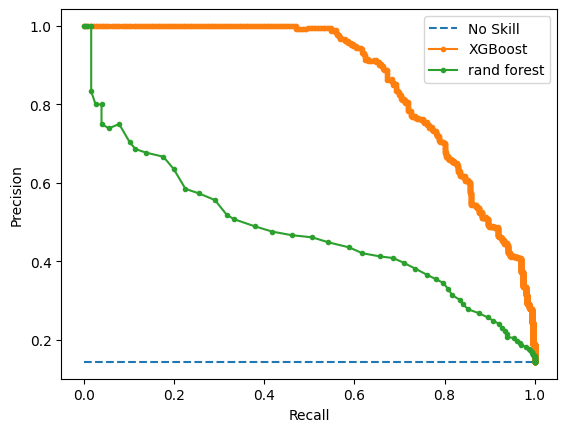

In [14]:
xgb1 = pickle.load(open('models/curr_models/xgBoost-f2-4-2.pkl', 'rb'))
randforest = pickle.load(open('models/curr_models/randforest-test.pkl', 'rb'))
# get brier score
print(f1_score(y_test, xgb1.predict(X_test)))
print(brier_score_loss(y_test, xgb1.predict_proba(X_test)[:, 1]))

# get roc auc score
print(roc_auc_score(y_test, xgb1.predict_proba(X_test)[:, 1]))

print(recall_score(y_test, xgb1.predict(X_test)))

# get precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb1.predict_proba(X_test)[:, 1])
# plot the precision-recall curves
print(auc(recall, precision))

print(average_precision_score(y_test, xgb1.predict_proba(X_test)[:, 1]))
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')


# plot precision recall for knn
precision, recall, thresholds = precision_recall_curve(y_test, randforest.predict_proba(X_test)[:, 1])
print(auc(recall, precision))
plt.plot(recall, precision, marker='.', label='rand forest')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


In [51]:
print(type(xgb1).__name__)

XGBClassifier


In [1]:
ds = dataset[f'f2-4']

X, y = ds['X'], ds['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"), n_estimators=1, n_jobs=-1)
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = -1), n_estimators = 1, n_jobs = -1)

# randforest.fit(X_train, y_train)
knn.fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1])
area = auc(recall, precision)


print('Area Under Curve: %.2f' % area)

x = cross_validate(knn, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])

for k, v in x.items():
    print(k, v.mean())
        # modelScores[name][k]=v.mean()

x = cross_validate(xgb1, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'])

for k, v in x.items():
    print(k, v.mean())
# print(accuracy_score(knn.predict(X_test), y_test))
# print(recall_score(knn.predict(X_test), y_test))


# print(accuracy_score(xgb1.predict(X_test), y_test))
# print(recall_score(xgb1.predict(X_test), y_test))
# print(f1_score(xgb1.predict(X_test), y_test))
# pickle.dump(xgb1, open('models/curr_models/xgBoost.pkl', 'wb'))

NameError: name 'dataset' is not defined

## Order models by performance

In [ ]:
score_df = pd.DataFrame(modelScores).T

# select model with best overall scores, precision doesn't really matter, excluding accuracy just because
score_df['total'] = score_df.apply(lambda x: x[['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score']].sum(), axis=1)
score_df['name'] = score_df.apply(lambda x: x.name.split("_")[0], axis=1)
score_df['feature'] = score_df.apply(lambda x: x.name.split("_")[1], axis=1)
score_df['kmer'] = score_df.apply(lambda x: x.name.split("_")[2], axis=1)
# sort based on total column
score_df = score_df.sort_values(by='test_f1', ascending=False)
# print(len(score_df))

# for each k-mer value, create a plot with the AUC score of each model and each feature and put it into one graph


# for kmer in modelKmers:
#     for name in modelNames:
#         for feature in modelFeatures:
#             df = score_df[score_df.index.str.contains(f'{name}_{feature}_{kmer}')]
#             df.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))
#             plt.title(f'{name} {feature} {kmer}')
#     plt.show()

# retrieve all model names
modelNames = score_df['name'].unique()

for kmer in range(3, 7):
    # for feature in features:

    for modelName in modelNames:
        # retrieve models that match the current name and k-mer
        df = score_df[score_df['name'] == modelName]
        df = df[df['kmer'] == str(kmer)]
        # rename all indices to the name of the model
        print(df)
        df.index = df.apply(lambda x: x.name.split("_")[0], axis=1)
        
        # plot the auc for 
        df.plot.bar(y=['test_roc_auc', 'test_accuracy'], figsize=(20, 10), rot=0, )
        plt.title(f'kmer = {kmer}, feature = {feature}')
    plt.show()

# xg_boost = score_df[score_df.index.str.contains(f'{name}_{feature}_{kmer}')]
# # mlp = score_df[score_df.index.str.contains('mlp')]
# # svm = score_df[score_df.index.str.contains('svm')]
# xg_boost.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))

# xg_boost.plot.bar(y=['test_f1', 'test_recall', 'test_roc_auc', 'test_neg_brier_score', 'test_accuracy'], figsize=(20, 10))
# pickle.dump(score_df, open('score_df.pkl', 'wb'))

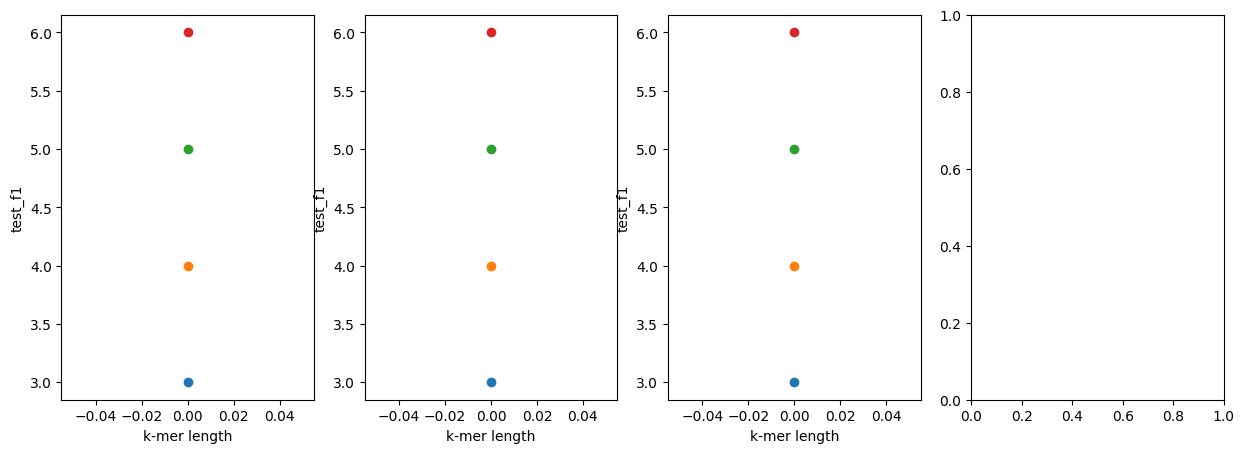

In [68]:
metric = 'test_f1'

# Create a figure and subplots for each feature
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Loop through each k-mer length
for length in range(3, 7):
    # Loop through each feature
    for i, feature in enumerate(['knn_f1', 'knn_f2', 'knn_f3']):
        # Extract the data for the current length and feature
        data = [modelScores[model][metric] for model in modelScores]
        # print(data)
        # Plot the data on the corresponding subplot
        axs[i].plot(length, 'o-')
        axs[i].set_xlabel('k-mer length')
        axs[i].set_ylabel(metric)

# Show the plot
plt.show()

## Dump models into pickle - TODO

### Grid-Searched version of the Gradient Boosting classifier

In [ ]:
ds = datasets['merged'][f'normalized-{kmer}']

X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

"""
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
"""

parameters={
   'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 42, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3
}

param_test1 = {'n_estimators':range(100,140,10), 'learning_rate':[0.1,0.15,0.2], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,9,1), 'min_samples_split':range(10,40,10), 'max_features':range(2, 5)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], max_features=parameters['max_features'], random_state=parameters['random_state']), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

# parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

### Load available models

In [ ]:
from itertools import combinations_with_replacement
def hidden_layers_generator(hidden_layers, max_neurons):
  hd_sizes = []
  comb = combinations_with_replacement(np.arange(100,max_neurons+10,20), hidden_layers)
  hd_sizes.append(list(comb))
  return hd_sizes


# ds = datasets['merged'][f'normalized-{kmer}']

# X_train, y_train, X_test, y_test = ds['X_train'], ds['y_train'], ds['X_test'], ds['y_test']

X = pd.concat([X_train, X_test])
y = np.concatenate([ds['y_train'], ds['y_test']], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print(l)
hlg = hidden_layers_generator(hidden_layers=5, max_neurons=200)
print(hlg)

mlp_gs = MLPClassifier(max_iter=350, random_state=42, solver='adam')

parameter_space = {
    'hidden_layer_sizes': hlg[0],
    'activation': ['relu'],
    'alpha': [0.05, 0.1, 0.2],
}
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5, verbose=10, scoring='recall')
clf.fit(X_train, y_train) # X is train samples and y is the corresponding labels

### Creation of the ensemble model

### Select the best current model

In [856]:


# score_df = score_df.sort_values(by=['test'], ascending=False)
a = set([x.split("_")[0] for x in score_df.index.to_list()])
print(a)

score_df

{'xgb', 'svm', 'knn', 'mlp', 'rf'}


,fit_time,score_time,test_recall,test_f1,test_accuracy,test_precision,test_roc_auc,test_neg_brier_score,total
mlp_f2_5,15.924036,0.425549,0.772120,0.644200,0.877951,0.576176,0.925820,-0.089756,2.252384
mlp_f2_4,11.089791,0.361498,0.776684,0.669933,0.888208,0.602893,0.924755,-0.081424,2.289948
mlp_f1_4,9.182259,0.385886,0.807202,0.660134,0.874936,0.568635,0.923644,-0.091251,2.299728
mlp_f1_6,51.713082,0.975803,0.802646,0.636191,0.865438,0.537411,0.922410,-0.094534,2.266713
mlp_f1_5,22.543625,0.448890,0.798760,0.635674,0.864683,0.545367,0.921641,-0.091369,2.264706
mlp_f2_3,12.340601,0.291237,0.768905,0.652754,0.885007,0.577477,0.921104,-0.081278,2.261485
mlp_f2_6,32.217857,0.711247,0.797466,0.631631,0.865719,0.537123,0.920247,-0.098666,2.250678
svm_f2_4,6.441675,3.110650,0.719567,0.680628,0.910978,0.675504,0.919531,-0.067792,2.251934
mlp_f3_3,12.692576,0.347511,0.838345,0.647370,0.849434,0.549583,0.918898,-0.106688,2.297925
mlp_f1_3,5.641986,0.342958,0.790981,0.612923,0.857063,0.507105,0.915888,-0.104020,2.215772


In [ ]:
# pretrained models
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MLP: f2_4
mlp = BalancedBaggingClassifier(base_estimator=MLPClassifier(alpha=0.6, hidden_layer_sizes=(100, 180, 180, 200, 200),
              max_iter=550, random_state=42, solver='adam', activation='relu'), n_estimators=5, n_jobs=-1)

mlp.fit(X_train.values, y_train)

# knn
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1, n_jobs=-1), n_estimators=1, n_jobs=-1)
knn.fit(X_train.values, y_train)

# SVM: f2_4
# temp_svm = BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42), n_estimators=10, n_jobs=-1)

# temp_svm.fit(X_train, y_train)

# RF: f2_4
randforest = BalancedRandomForestClassifier(max_features="sqrt", n_jobs=-1)

randforest.fit(X_train.values, y_train)

# XGBoost: f2_4
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=200,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        #  scale_pos_weight=1,
        seed=42,
        n_jobs=-1,
        scale_pos_weight=6,
)
X_train_xg, X_validation, y_train_xg, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

xgb1.fit(X_train_xg.values, y_train_xg, eval_metric='aucpr', eval_set=[(X_validation.values, y_validation)], early_stopping_rounds=20, verbose=10)
# print("cross validating stacking classifier")
# print(em.cross_validate(X, y, cv=5))
# xgb1 = pickle.load(open('models/curr_models/xgb1-test.pkl', 'rb'))


# xgb1.fit(X_train, y_train)

# em = StackingCVClassifier(classifiers = [mlp, randforest, xgb1],
#                             # shuffle = True,
#                             use_probas = True,
#                             cv = 5,
#                             use_features_in_secondary=True,
#                             meta_classifier = LogisticRegression(C = 1, random_state=42, solver='saga'), n_jobs=-1, random_state=42, verbose=1, store_train_meta_features=True)
# x = cross_validate(em, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'], verbose=1, n_jobs=-1)
# name = 'ensemble_lengthdiv_4'
# if (name not in modelScores):
#     modelScores[name] = {}
#     for k, v in x.items():
#         print(k, v.mean())
#         modelScores[name][k]=v.mean()
# else:
#     print('already in modelScores')
# em.fit(X_train, y_train)

In [519]:
class StackingClassifier():
    def __init__(self, classifiers, meta_classifier, n_folds=5, use_probas=True):
        self.classifiers = classifiers # assume pretrained
        self.meta_classifier = meta_classifier # logistic regression
        self.n_folds = n_folds
        self.X_train_new=None
        self.X_test_new=None
        self.y_train_new=None
        self.use_probas = use_probas
        self.feature_names_in = None

    def fit_pretrained(self, X_train, y_train):
        self.X_train_new = np.zeros((X_train.shape[0], len(self.classifiers)))
        self.y_train_new = y_train
        print(X_train.shape[0], len(y_train))
        
        for i, clf in enumerate(self.classifiers):
            if self.use_probas:
                self.X_train_new[:, i] = model.predict_proba(X_train)[:,1]
            else:
                self.X_train_new[:, i] = model.predict(X_train)

        print(len(self.X_train_new))
        
        self.meta_classifier = self.meta_classifier.fit(self.X_train_new, self.y_train_new)

    def fit_not_pretrained(self, X_train, y_train, cv = 10): # assume NOT pretrained
        print(X_train.shape[0], len(y_train))
        kfold = StratifiedKFold(n_splits=cv, random_state=42, shuffle=True)

        out_of_fold_predictions = np.zeros((X_train.shape[0], len(self.classifiers)))
        
        # Iterate over the folds

        for i, clf in enumerate(self.classifiers):
            for train_index, holdout_index in kfold.split(X_train, y_train):
                # instance = clone(clf)
                # self.base_estimators_[i].append(instance)
                if type(clf).__name__ == 'XGBClassifier':
                    print("xgboost detected")
                    X_train_xg, X_val, y_train_xg, y_val = train_test_split(X_train[train_index], y_train[train_index], test_size=0.15, random_state=1)
                    self.classifiers[i] = clf.fit(X_train_xg, y_train_xg, eval_metric='aucpr', eval_set=[(X_val, y_val)], early_stopping_rounds=20, verbose=10)
                    
                    if self.use_probas:
                        y_pred = clf.predict_proba(X_train[holdout_index])[:,1]
                        out_of_fold_predictions[holdout_index, i] = y_pred # set indexhere to the prediction value
                    else:
                        y_pred = clf.predict(X_train[holdout_index])
                        out_of_fold_predictions[holdout_index, i] = y_pred # set indexhere to the prediction value
                else:
                    self.classifiers[i]=clf.fit(X_train[train_index], y_train[train_index])
                    if self.use_probas:
                        y_pred = clf.predict_proba(X_train[holdout_index])[:,1]
                        out_of_fold_predictions[holdout_index, i] = y_pred # set indexhere to the prediction value
                    else:
                        y_pred = clf.predict(X_train[holdout_index])
                        out_of_fold_predictions[holdout_index, i] = y_pred # set indexhere to the prediction value

        
        self.meta_classifier.fit(out_of_fold_predictions, y_train)
        pickle.dump(out_of_fold_predictions, open("base_predictions.pkl", "wb"))
        pickle.dump(y_train, open("y_truth.pkl", "wb"))
        # return self


        # for train_index, val_index in kfold.split(X_train, y_train):
        #     X_train_temp, X_validation = X_train[train_index], X_train[val_index]
        #     y_train_temp, y_validation = y_train[train_index], y_train[val_index]


        #     for index, clf in enumerate(self.classifiers):
        #         print(type(clf).__name__)
        #         if type(clf).__name__ != 'XGBClassifier':
        #             self.classifiers[index] = clf.fit(X_train_temp, y_train_temp)
        #             training_acc = clf.score(X_train_temp, y_train_temp)
        #             print("training accuracy: ", training_acc)

        #         else:
        #             print("xgboost detected")
        #             X_train_xg, X_val, y_train_xg, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=1)
        #             self.classifiers[index] = clf.fit(X_train_xg, y_train_xg, eval_metric='aucpr', eval_set=[(X_val, y_val)], early_stopping_rounds=5, verbose=10)
        #             # self.feature_names_in = clf.get_booster().feature_names
        #             training_acc = clf.score(X_train_xg, y_train_xg)
        #             print("training accuracy: ", training_acc)
            
        #     # predictions of the validation set by EACH model

        #     fold_predictions = []
        #     for classifier in self.classifiers:
        #         if self.use_probas:
        #             fold_predictions.append(classifier.predict_proba(X_validation)[:,1])
        #         else:
        #             fold_predictions.append(classifier.predict(X_validation))
            
        #     base_predictions.append(fold_predictions)
        #     y_truth.append(y_validation)

        # print(base_predictions)
        # pickle.dump(base_predictions, open("base_predictions.pkl", "wb"))
        # pickle.dump(y_truth, open("y_truth.pkl", "wb"))
        
        # self.meta_classifier = self.meta_classifier.fit(np.array(base_predictions, dtype=object), np.array(y_truth, dtype=object))


    def predict(self, X):
        # make 
        meta_features = np.column_stack([
            clf.predict(X) for clf in self.classifiers
        ])
        return self.meta_classifier.predict(meta_features)

    def predict_proba(self, X):
        meta_features = np.column_stack([
            clf.predict_proba(X)[:,1] for clf in self.classifiers
        ])
        return self.meta_classifier.predict_proba(meta_features)

    def cross_validate(self, X, y, scoring=['precision', 'recall', 'f1', 'average_precision', 'reg_prec', 'log_loss', 'neg_brier_score', 'roc_auc', 'accuracy'], cv=5):
        kfold = StratifiedKFold(n_splits=cv, random_state=42, shuffle=True)
        scores = {s: [] for s in scoring}
        metrics = {
            'recall': recall_score,
            'f1': f1_score,
            'accuracy': accuracy_score,
            'precision': precision_score,
            'roc_auc': roc_auc_score,
            'neg_brier_score': brier_score_loss,
            'average_precision': average_precision_score,
            'reg_prec': precision_recall_curve,
            'log_loss': log_loss
        }
        for train_index, test_index in kfold.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
            self.fit_not_pretrained(X_train, y_train)
            if self.use_probas:
                # print(y_pred.sum())
                for s in scoring:
                    if s == 'reg_prec' or s == 'average_precision' or s == 'neg_brier_score' or s == 'log_loss' or s == 'roc_auc':
                        y_pred = self.predict_proba(X_test)[:,1]
                        if s == 'reg_prec':
                            precision, recall, _ = metrics[s](y_test, y_pred)
                            print("auc: ", auc(recall, precision))
                            scores[s].append((recall, precision))
                            # print('regprec', auc(recall, precision))
                        else:
                            scores[s].append(metrics[s](y_test, y_pred))
                        # print('regprec', auc(recall, precision))
                    else:
                        y_pred = self.predict(X_test)
                        scores[s].append(metrics[s](y_test, y_pred))
            else:
                # print("not use probas")
                y_pred = self.predict(X_test)

                # print(y_pred.sum())

                for s in scoring:
                    met = metrics[s](y_test, y_pred)
                    # print(s, met)
                    scores[s].append(met)

        return scores
    

In [520]:
#LogisticRegression(C = 1, random_state=42, solver='saga')
# BalancedBaggingClassifier(base_estimator=SVC(kernel='rbf', C=2, gamma=0.6, probability=True, random_state=42), n_jobs=-1)
em = StackingClassifier(classifiers = [mlp, randforest, xgb1], use_probas = True, meta_classifier = LogisticRegression(C = 1, random_state=42, solver='saga'))


In [469]:
em.fit_pretrained(X_train.values, y_train)

8501 8501
8501


In [ ]:
l = cross_validate(mlp, X, y, scoring=['precision', 'recall', 'f1', 'average_precision'], cv=10)
print([(x, np.array(l[x]).mean()) for x in l])

In [521]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cv = em.cross_validate(X.values, y, cv=10)

(9564, 256) (1063, 256) (9564,) (1063,)
9564 9564
xgboost detected
[0]	validation_0-aucpr:0.53870


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.75177
[20]	validation_0-aucpr:0.78670
[30]	validation_0-aucpr:0.79605
[40]	validation_0-aucpr:0.80241
[50]	validation_0-aucpr:0.80954
[60]	validation_0-aucpr:0.81664
[70]	validation_0-aucpr:0.81990
[80]	validation_0-aucpr:0.82106
[90]	validation_0-aucpr:0.82339
[100]	validation_0-aucpr:0.82563
[110]	validation_0-aucpr:0.82824
[120]	validation_0-aucpr:0.82950
[130]	validation_0-aucpr:0.83123
[140]	validation_0-aucpr:0.83264
[150]	validation_0-aucpr:0.83312
[160]	validation_0-aucpr:0.83420
[170]	validation_0-aucpr:0.83413
[180]	validation_0-aucpr:0.83626
[190]	validation_0-aucpr:0.83697
[199]	validation_0-aucpr:0.83691
xgboost detected
[0]	validation_0-aucpr:0.60406
[10]	validation_0-aucpr:0.78914
[20]	validation_0-aucpr:0.80468
[30]	validation_0-aucpr:0.82289
[40]	validation_0-aucpr:0.82933
[50]	validation_0-aucpr:0.83877
[60]	validation_0-aucpr:0.84766
[70]	validation_0-aucpr:0.85112
[80]	validation_0-aucpr:0.85462
[90]	validation_0-aucpr:0.85725
[100]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.76763
[20]	validation_0-aucpr:0.79837
[30]	validation_0-aucpr:0.81333
[40]	validation_0-aucpr:0.82391
[50]	validation_0-aucpr:0.83244
[60]	validation_0-aucpr:0.83611
[70]	validation_0-aucpr:0.83848
[80]	validation_0-aucpr:0.84428
[90]	validation_0-aucpr:0.84674
[100]	validation_0-aucpr:0.85105
[110]	validation_0-aucpr:0.85053
[120]	validation_0-aucpr:0.85118
[130]	validation_0-aucpr:0.85203
[138]	validation_0-aucpr:0.85171
xgboost detected
[0]	validation_0-aucpr:0.57951
[10]	validation_0-aucpr:0.78973
[20]	validation_0-aucpr:0.81319
[30]	validation_0-aucpr:0.82916
[40]	validation_0-aucpr:0.83885
[50]	validation_0-aucpr:0.84227
[60]	validation_0-aucpr:0.84789
[70]	validation_0-aucpr:0.84902
[80]	validation_0-aucpr:0.85427
[90]	validation_0-aucpr:0.86026
[100]	validation_0-aucpr:0.86254
[110]	validation_0-aucpr:0.86394
[120]	validation_0-aucpr:0.86565
[130]	validation_0-aucpr:0.86724
[140]	validation_0-aucpr:0.86940
[150]	validation_0-aucpr:0.86898
[160]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.76498
[20]	validation_0-aucpr:0.78103
[30]	validation_0-aucpr:0.79531
[40]	validation_0-aucpr:0.80647
[50]	validation_0-aucpr:0.81091
[60]	validation_0-aucpr:0.81665
[70]	validation_0-aucpr:0.82404
[80]	validation_0-aucpr:0.82835
[90]	validation_0-aucpr:0.83172
[100]	validation_0-aucpr:0.83499
[110]	validation_0-aucpr:0.83818
[120]	validation_0-aucpr:0.84045
[130]	validation_0-aucpr:0.84188
[140]	validation_0-aucpr:0.84358
[150]	validation_0-aucpr:0.84425
[160]	validation_0-aucpr:0.84590
[170]	validation_0-aucpr:0.84583
[180]	validation_0-aucpr:0.84648
[190]	validation_0-aucpr:0.84781
[199]	validation_0-aucpr:0.84897
xgboost detected
[0]	validation_0-aucpr:0.61044
[10]	validation_0-aucpr:0.74589
[20]	validation_0-aucpr:0.76929
[30]	validation_0-aucpr:0.78870
[40]	validation_0-aucpr:0.80021
[50]	validation_0-aucpr:0.80426
[60]	validation_0-aucpr:0.81008
[70]	validation_0-aucpr:0.81424
[80]	validation_0-aucpr:0.81676
[90]	validation_0-aucpr:0.82127
[100]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.83230
[20]	validation_0-aucpr:0.84984
[30]	validation_0-aucpr:0.85205
[40]	validation_0-aucpr:0.85448
[50]	validation_0-aucpr:0.86112
[60]	validation_0-aucpr:0.86784
[70]	validation_0-aucpr:0.86877
[80]	validation_0-aucpr:0.87253
[90]	validation_0-aucpr:0.87578
[100]	validation_0-aucpr:0.87629
[110]	validation_0-aucpr:0.87635
[120]	validation_0-aucpr:0.87906
[130]	validation_0-aucpr:0.88005
[140]	validation_0-aucpr:0.88040
[150]	validation_0-aucpr:0.88136
[160]	validation_0-aucpr:0.88222
[170]	validation_0-aucpr:0.88331
[180]	validation_0-aucpr:0.88310
[183]	validation_0-aucpr:0.88330
xgboost detected
[0]	validation_0-aucpr:0.59486
[10]	validation_0-aucpr:0.77877
[20]	validation_0-aucpr:0.81464
[30]	validation_0-aucpr:0.82937
[40]	validation_0-aucpr:0.83818
[50]	validation_0-aucpr:0.84373
[60]	validation_0-aucpr:0.84573
[70]	validation_0-aucpr:0.84876
[80]	validation_0-aucpr:0.85206
[90]	validation_0-aucpr:0.85444
[100]	validation_0-aucpr:0.85661
[110]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.77385
[20]	validation_0-aucpr:0.79632
[30]	validation_0-aucpr:0.81049
[40]	validation_0-aucpr:0.82200
[50]	validation_0-aucpr:0.83254
[60]	validation_0-aucpr:0.83986
[70]	validation_0-aucpr:0.84637
[80]	validation_0-aucpr:0.84730
[90]	validation_0-aucpr:0.85162
[100]	validation_0-aucpr:0.85260
[110]	validation_0-aucpr:0.85469
[120]	validation_0-aucpr:0.85689
[130]	validation_0-aucpr:0.85599
[140]	validation_0-aucpr:0.85662
[141]	validation_0-aucpr:0.85704
xgboost detected
[0]	validation_0-aucpr:0.58663
[10]	validation_0-aucpr:0.77374
[20]	validation_0-aucpr:0.80871
[30]	validation_0-aucpr:0.82046
[40]	validation_0-aucpr:0.82822
[50]	validation_0-aucpr:0.83731
[60]	validation_0-aucpr:0.84608
[70]	validation_0-aucpr:0.85091
[80]	validation_0-aucpr:0.85509
[90]	validation_0-aucpr:0.85676
[100]	validation_0-aucpr:0.85836
[110]	validation_0-aucpr:0.85928
[120]	validation_0-aucpr:0.86186
[130]	validation_0-aucpr:0.86306
[140]	validation_0-aucpr:0.86319
[150]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.76957
[20]	validation_0-aucpr:0.80517
[30]	validation_0-aucpr:0.81832
[40]	validation_0-aucpr:0.81915
[50]	validation_0-aucpr:0.82888
[60]	validation_0-aucpr:0.83470
[70]	validation_0-aucpr:0.83819
[80]	validation_0-aucpr:0.84033
[90]	validation_0-aucpr:0.84233
[100]	validation_0-aucpr:0.84539
[110]	validation_0-aucpr:0.84528
[120]	validation_0-aucpr:0.84657
[130]	validation_0-aucpr:0.84588
[140]	validation_0-aucpr:0.84702
[150]	validation_0-aucpr:0.84771
[160]	validation_0-aucpr:0.84820
[170]	validation_0-aucpr:0.84669
[173]	validation_0-aucpr:0.84692
xgboost detected
[0]	validation_0-aucpr:0.56513
[10]	validation_0-aucpr:0.77404
[20]	validation_0-aucpr:0.80445
[30]	validation_0-aucpr:0.81470
[40]	validation_0-aucpr:0.82772
[50]	validation_0-aucpr:0.83327
[60]	validation_0-aucpr:0.83758
[70]	validation_0-aucpr:0.84101
[80]	validation_0-aucpr:0.84145
[90]	validation_0-aucpr:0.84203
[100]	validation_0-aucpr:0.84685
[110]	validation_0-aucpr:0.84835
[120]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.76771
[20]	validation_0-aucpr:0.78790
[30]	validation_0-aucpr:0.80442
[40]	validation_0-aucpr:0.81776
[50]	validation_0-aucpr:0.82161
[60]	validation_0-aucpr:0.82514
[70]	validation_0-aucpr:0.82977
[80]	validation_0-aucpr:0.83053
[90]	validation_0-aucpr:0.83218
[100]	validation_0-aucpr:0.83518
[110]	validation_0-aucpr:0.83700
[120]	validation_0-aucpr:0.83658
[130]	validation_0-aucpr:0.83858
[140]	validation_0-aucpr:0.84093
[150]	validation_0-aucpr:0.84183
[160]	validation_0-aucpr:0.84331
[170]	validation_0-aucpr:0.84619
[180]	validation_0-aucpr:0.84691
[190]	validation_0-aucpr:0.84658
[199]	validation_0-aucpr:0.84630
xgboost detected
[0]	validation_0-aucpr:0.59835
[10]	validation_0-aucpr:0.73789
[20]	validation_0-aucpr:0.76913
[30]	validation_0-aucpr:0.78546
[40]	validation_0-aucpr:0.79057
[50]	validation_0-aucpr:0.79422
[60]	validation_0-aucpr:0.80160
[70]	validation_0-aucpr:0.80881
[80]	validation_0-aucpr:0.80962
[90]	validation_0-aucpr:0.81329
[100]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.79587
[20]	validation_0-aucpr:0.82124
[30]	validation_0-aucpr:0.83342
[40]	validation_0-aucpr:0.84224
[50]	validation_0-aucpr:0.84755
[60]	validation_0-aucpr:0.85304
[70]	validation_0-aucpr:0.85441
[80]	validation_0-aucpr:0.85624
[90]	validation_0-aucpr:0.85615
[100]	validation_0-aucpr:0.85896
[110]	validation_0-aucpr:0.85980
[120]	validation_0-aucpr:0.85774
[124]	validation_0-aucpr:0.85843
xgboost detected
[0]	validation_0-aucpr:0.51663
[10]	validation_0-aucpr:0.74092
[20]	validation_0-aucpr:0.77419
[30]	validation_0-aucpr:0.78907
[40]	validation_0-aucpr:0.80099
[50]	validation_0-aucpr:0.80525
[60]	validation_0-aucpr:0.80766
[70]	validation_0-aucpr:0.81113
[80]	validation_0-aucpr:0.81464
[90]	validation_0-aucpr:0.81545
[100]	validation_0-aucpr:0.81889
[110]	validation_0-aucpr:0.82050
[120]	validation_0-aucpr:0.82263
[130]	validation_0-aucpr:0.82356
[140]	validation_0-aucpr:0.82330
[150]	validation_0-aucpr:0.82455
[160]	validation_0-aucpr:0.82503
[170]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.75050
[20]	validation_0-aucpr:0.77555
[30]	validation_0-aucpr:0.78338
[40]	validation_0-aucpr:0.79465
[50]	validation_0-aucpr:0.80567
[60]	validation_0-aucpr:0.81401
[70]	validation_0-aucpr:0.81805
[80]	validation_0-aucpr:0.82251
[90]	validation_0-aucpr:0.82311
[100]	validation_0-aucpr:0.82746
[110]	validation_0-aucpr:0.82795
[120]	validation_0-aucpr:0.82882
[130]	validation_0-aucpr:0.82889
[140]	validation_0-aucpr:0.82938
[150]	validation_0-aucpr:0.83104
[160]	validation_0-aucpr:0.83247
[170]	validation_0-aucpr:0.83377
[180]	validation_0-aucpr:0.83554
[190]	validation_0-aucpr:0.83573
[199]	validation_0-aucpr:0.83588
xgboost detected
[0]	validation_0-aucpr:0.62140
[10]	validation_0-aucpr:0.77900
[20]	validation_0-aucpr:0.79627
[30]	validation_0-aucpr:0.80813
[40]	validation_0-aucpr:0.81601
[50]	validation_0-aucpr:0.82531
[60]	validation_0-aucpr:0.82971
[70]	validation_0-aucpr:0.82913
[80]	validation_0-aucpr:0.83220
[90]	validation_0-aucpr:0.83590
[100]	validat

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-aucpr:0.80753
[20]	validation_0-aucpr:0.82319
[30]	validation_0-aucpr:0.82914
[40]	validation_0-aucpr:0.82586
[50]	validation_0-aucpr:0.83119
[60]	validation_0-aucpr:0.83671
[70]	validation_0-aucpr:0.84040
[80]	validation_0-aucpr:0.84292
[90]	validation_0-aucpr:0.84287
[100]	validation_0-aucpr:0.84316
[110]	validation_0-aucpr:0.84459
[120]	validation_0-aucpr:0.84703
[130]	validation_0-aucpr:0.84991
[140]	validation_0-aucpr:0.85118
[150]	validation_0-aucpr:0.85164
[160]	validation_0-aucpr:0.85249
[170]	validation_0-aucpr:0.85300
[180]	validation_0-aucpr:0.85453
[190]	validation_0-aucpr:0.85480
[199]	validation_0-aucpr:0.85540
xgboost detected
[0]	validation_0-aucpr:0.58391
[10]	validation_0-aucpr:0.77280
[20]	validation_0-aucpr:0.79126
[30]	validation_0-aucpr:0.80580
[40]	validation_0-aucpr:0.81063
[50]	validation_0-aucpr:0.81703
[60]	validation_0-aucpr:0.81914
[70]	validation_0-aucpr:0.82094
[80]	validation_0-aucpr:0.82686
[90]	validation_0-aucpr:0.82878
[100]	validat

In [619]:
pickle.dump(em, open("models/curr_models/em_curr.pkl", "wb"))

## Load models

In [732]:
model_scores = {}

In [618]:
print(average_precision_score(y_test, em.predict_proba(X_test)[:,1]))
print(average_precision_score(y_test, mlp.predict_proba(X_test)[:,1]))
print(average_precision_score(y_test, knn.predict_proba(X_test)[:,1]))

/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedRandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  warnings.warn(


0.9806535156619021
0.9234035679966046


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but BalancedBaggingClassifier was fitted without feature names
  warnings.warn(


0.44914889500504096


In [733]:
# get testing knn to compare against
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1, n_jobs=-1), n_estimators=1, n_jobs=-1)
knn.fit(X_train.values, y_train)

print("validating knn")
name = 'knn'
x = cross_validate(knn, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision', 'neg_log_loss'])
if (name not in model_scores):
    model_scores[name] = {}
    for k, v in x.items():
        print(k, v.mean())
        model_scores[name][k]=v.mean()
else:
    for k, v in x.items():
        print(k, v.mean())
    print('already in model_scores')

pickle.dump(knn, open("models/curr_models/knn-f2-4.pkl", "wb"))

validating knn
fit_time 0.026024723052978517
score_time 0.06587142944335937
test_recall 0.8150146627565983
test_f1 0.6110526831107261
test_accuracy 0.8429206683284525
test_precision 0.4932516729596748
test_roc_auc 0.8313255612189044
test_neg_brier_score -0.1570793316715475
test_average_precision 0.44561658896499645
test_neg_log_loss -5.425432062692812


In [704]:
# print(model_scores['xgb'])
print(model_scores['knn'])

{'fit_time': 10.244130396842957, 'score_time': 0.016333603858947755, 'test_recall': 0.6398031001256806, 'test_f1': 0.6829527889895828, 'test_accuracy': 0.9286552644772902, 'test_precision': 0.7846102218406485, 'test_roc_auc': 0.9296230077239439, 'test_neg_brier_score': -0.05695592667464675, 'test_average_precision': 0.7919794174563275, 'test_neg_log_loss': -0.21983037778213302}


In [858]:
print("validating svm")
name = 'svm'
x = cross_validate(temp_svm, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision', 'neg_log_loss'])
if (name not in model_scores):
    model_scores[name] = {}
    for k, v in x.items():
        print(k, v.mean())
        model_scores[name][k]=v.mean()
else:
    for k, v in x.items():
        print(k, v.mean())
    print('already in model_scores')

validating svm
fit_time 3.9646480798721315
score_time 1.0298492908477783
test_recall 0.729995810640972
test_f1 0.69226350810925
test_accuracy 0.9109645090025211
test_precision 0.6698081190539307
test_roc_auc 0.9111827763248929
test_neg_brier_score -0.06980165959144655
test_average_precision 0.7538108072642846
test_neg_log_loss -0.24872697009732292


In [734]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']

print(cv.keys())
name = 'ensemble'
if name not in model_scores:
    model_scores[name] = {}
    for k, v in cv.items():
        if k != 'reg_prec':
            print(k, mean(v))
            model_scores[name]["test_"+ k] = mean(v)
        if k == 'log_loss':
            model_scores[name]["test_neg_"+ k] = -1*mean(v)
        else:
            model_scores[name][k]= v
# print(model_scores)

# pickle.dump(cv, open("cv.pkl", "wb"))
#     # print(x, np.array(cv[x]).mean())
# print(len(cv['reg_prec'][0]))
# for x in cv['reg_prec']:
#     # for each model
#     print(np.mean(x))
#     # print(np.mean(x[0]), np.mean(x[1]))

# knn

print(model_scores)

# rf
print("validating rf")
name = 'random forest'
x = cross_validate(randforest, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision', 'neg_log_loss'])
if (name not in model_scores):
    model_scores[name] = {}
    for k, v in x.items():
        print(k, v.mean())
        model_scores[name][k]=v.mean()
else:
    for k, v in x.items():
        print(k, v.mean())
    print('already in model_scores')


# mlp
print("validating mlp")
name = 'mlp'
x = cross_validate(mlp, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision', 'neg_log_loss'])
if (name not in model_scores):
    model_scores[name] = {}
    for k, v in x.items():
        print(k, v.mean())
        model_scores[name][k]=v.mean()
else:
    for k, v in x.items():
        print(k, v.mean())
    print('already in model_scores')

# # xgb
print("validating xgb")
name='xgb'
x = cross_validate(xgb1, X, y, cv=10, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision', 'neg_log_loss'])
if (name not in model_scores):
    model_scores[name] = {}
    for k, v in x.items():
        print(k, v.mean())
        model_scores[name][k]=v.mean()
# else:
#     for k, v in x.items():
#         print(k, v.mean())
#     print('already in model_scores')

dict_keys(['precision', 'recall', 'f1', 'average_precision', 'reg_prec', 'log_loss', 'neg_brier_score', 'roc_auc', 'accuracy'])
precision 0.6550387265681046
recall 0.8073648931713449
f1 0.7225593248667845
average_precision 0.8617159616630096
log_loss 0.1691985513793655
neg_brier_score 0.0484785127295619
roc_auc 0.958279415620971
accuracy 0.9098534333239436
{'knn': {'fit_time': 0.026024723052978517, 'score_time': 0.06587142944335937, 'test_recall': 0.8150146627565983, 'test_f1': 0.6110526831107261, 'test_accuracy': 0.8429206683284525, 'test_precision': 0.4932516729596748, 'test_roc_auc': 0.8313255612189044, 'test_neg_brier_score': -0.1570793316715475, 'test_average_precision': 0.44561658896499645, 'test_neg_log_loss': -5.425432062692812}, 'ensemble': {'test_precision': 0.6550387265681046, 'precision': [0.7103825136612022, 0.6287128712871287, 0.6275510204081632, 0.6555555555555556, 0.5970873786407767, 0.6598984771573604, 0.6479591836734694, 0.6578947368421053, 0.7195121951219512, 0.64583

In [736]:
pickle.dump(model_scores, open("model_scores.pkl", "wb"))

In [746]:
def test(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Initialize lists to store the precision, recall, and AUC values for each fold
    precision_list = []
    recall_list = []
    auc_list = []

    # Loop through each fold
    print("beginning cv")
    for train_index, test_index in skf.split(X, y):
        # Split the data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Train the model on the training data
        if type(model).__name__ == 'StackingClassifier':
            model.fit_not_pretrained(X_train, y_train)
        else:
            model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = model.predict(X_test)
        
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        
        # Calculate AUC
        auc_val = auc(recall, precision)
        
        # Store the precision, recall, and AUC values for this fold
        precision_list.append(precision)
        recall_list.append(recall)
        auc_list.append(auc_val)

    # Calculate the mean and standard deviation of the AUC across all folds
    mean_auc = np.mean(auc_list)
    std_auc = np.std(auc_list)
    mean_recall = np.mean(recall_list, axis=0)
    mean_precision = np.mean(precision_list, axis=0)


    # Plot the mean precision-recall curve, along with the standard deviation
    plt.plot(mean_recall, mean_precision, color='b', label='Mean AUC = %0.2f $\pm$ %0.2f' % (mean_auc, std_auc))
    # plt.show()
    

In [859]:
print(model_scores.keys())
print(model_scores['ensemble'].keys())

dict_keys(['knn', 'ensemble', 'random forest', 'mlp', 'xgb', 'svm'])
dict_keys(['test_precision', 'test_recall', 'test_f1', 'test_average_precision', 'test_log_loss', 'test_neg_log_loss', 'test_neg_brier_score', 'test_roc_auc', 'test_accuracy'])
{'knn': {'fit_time': 0.026024723052978517, 'score_time': 0.06587142944335937, 'test_recall': 0.8150146627565983, 'test_f1': 0.6110526831107261, 'test_accuracy': 0.8429206683284525, 'test_precision': 0.4932516729596748, 'test_roc_auc': 0.8313255612189044, 'test_neg_brier_score': -0.1570793316715475, 'test_average_precision': 0.44561658896499645, 'test_neg_log_loss': -5.425432062692812}, 'ensemble': {'test_precision': 0.6550387265681046, 'test_recall': 0.8073648931713449, 'test_f1': 0.7225593248667845, 'test_average_precision': 0.8617159616630096, 'test_log_loss': 0.1691985513793655, 'test_neg_log_loss': -0.1691985513793655, 'test_neg_brier_score': 0.0484785127295619, 'test_roc_auc': 0.958279415620971, 'test_accuracy': 0.9098534333239436}, 'rando

0.8617159616630096 0.44561658896499645
knn test_average_precision 0.9337609572939352
knn roc 0.1527125597051587
knn f1 0.1824828608695476
knn acc 0.0794057703297532
knn prec 0.3280010235700842
knn brier 1.3086243887956588
knn neg loss 0.9688138106930073
knn recall -0.009386051484497048
0.8617159616630096 0.8617159616630096
ensemble brier 0.0484785127295619
ensemble logloss -0.1691985513793655
ensemble ap 0.8617159616630096
ensemble roc 0.958279415620971
ensemble f1 0.7225593248667845
ensemble acc 0.9098534333239436
ensemble prec 0.6550387265681046
0.8617159616630096 0.752971606013702
random forest test_average_precision 0.1444202607121
random forest roc 0.046740741932755424
random forest f1 0.16148542645587952
random forest acc 0.06983749836473464
random forest prec 0.29007764288868415
random forest brier 1.4534589013668477
random forest neg loss 0.5112954772622278
random forest recall -0.021035360334046085
0.8617159616630096 0.766508610394388
mlp test_average_precision 0.1242091086486

<AxesSubplot: >

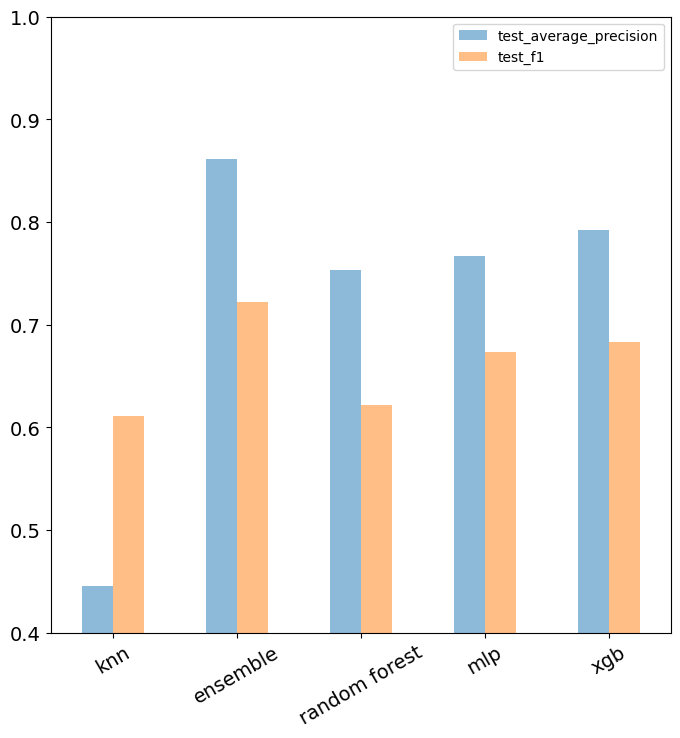

In [857]:
for k, v in model_scores.items():
    # graph each model's precision recall curve
    print(model_scores['ensemble']['test_average_precision'], v['test_average_precision'])
    if k == 'ensemble':
        print(k, 'brier', (model_scores['ensemble']['test_neg_brier_score']))
        print(k, 'logloss', (model_scores['ensemble']['test_neg_log_loss']))
        print(k, 'ap', (model_scores['ensemble']['test_average_precision']))
        print(k, 'roc', (model_scores['ensemble']['test_roc_auc']))
        print(k, 'f1', (model_scores['ensemble']['test_f1']))
        print(k, 'acc', (model_scores['ensemble']['test_accuracy']))
        print(k, 'prec', (model_scores['ensemble']['test_precision']))
        continue
    print(k, 'test_average_precision', (model_scores['ensemble']['test_average_precision'] - v['test_average_precision'])/v['test_average_precision'])
    print(k, 'roc', (model_scores['ensemble']['test_roc_auc'] - v['test_roc_auc'])/v['test_roc_auc'])
    print(k, 'f1', (model_scores['ensemble']['test_f1'] - v['test_f1'])/v['test_f1'])
    print(k, 'acc', (model_scores['ensemble']['test_accuracy'] - v['test_accuracy'])/v['test_accuracy'])
    print(k, 'prec', (model_scores['ensemble']['test_precision'] - v['test_precision'])/v['test_precision'])
    print(k, 'brier', -(model_scores['ensemble']['test_neg_brier_score'] - v['test_neg_brier_score'])/v['test_neg_brier_score'])
    print(k, 'neg loss', -(model_scores['ensemble']['test_neg_log_loss'] - v['test_neg_log_loss'])/v['test_neg_log_loss'])
    print(k, 'recall', (model_scores['ensemble']['test_recall'] - v['test_recall'])/v['test_recall'])
    


df = pd.DataFrame.from_dict(model_scores).T
df.dtypes
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
        print("success")
    except:
        continue

df[['test_average_precision', 'test_f1']].plot.bar(figsize=(8, 8), ylim=(0.4, 1), alpha=0.5, rot=30, fontsize=14)


# df[['test_average_precision', 'test_roc_auc', 'test_f1']].plot.bar(y=['test_average_precision', 'test_roc_auc', 'test_f1'], figsize=(8, 8), ylim=(0.4, 1), alpha=0.5)

# increase alpha for the second bar plot
# df.loc['ensemble'].plot.bar(y=['test_average_precision', 'test_roc_auc', 'test_f1'], figsize=(8,8),ylim=(0.4, 1),alpha=1.0)



max len x: 8502
max len y: 8502
8501 2126
fit done
auc split:  0.8402422346988428
precision len:  102
recall len:  102
8501 2126
fit done
auc split:  0.8068067406960936
precision len:  102
recall len:  102
8502 2125
fit done
auc split:  0.8160966213497813
precision len:  102
recall len:  102
8502 2125
fit done
auc split:  0.8425671945548125
precision len:  102
recall len:  102
8502 2125
fit done
auc split:  0.8055104367184235
precision len:  102
recall len:  102
max len x: 8502
max len y: 8502
8501 2126
fit done
auc split:  0.700727803582885
precision len:  3
recall len:  3
8501 2126
fit done
auc split:  0.6864220340665463
precision len:  3
recall len:  3
8502 2125
fit done
auc split:  0.6777676493862451
precision len:  3
recall len:  3
8502 2125
fit done
auc split:  0.6690509660368146
precision len:  3
recall len:  3
8502 2125
fit done
auc split:  0.6796306237482709
precision len:  3
recall len:  3


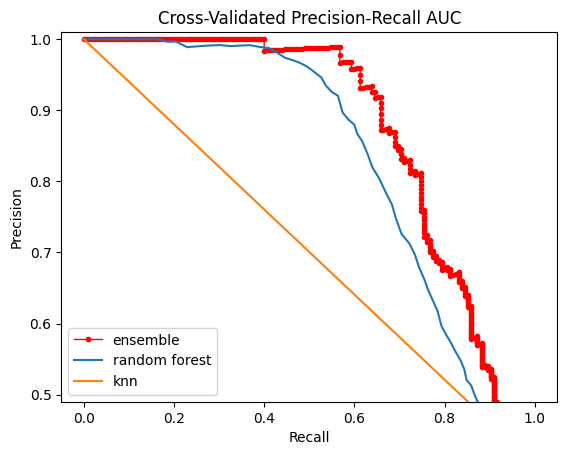

In [844]:
# plot precision recall for each model
# ds = dataset['f2-4']
# X, y = ds['X'], ds['y']
# for k, v in model_scores.items():
#     # graph each model's precision recall curve
#     print(k, v['test_average_precision'])
#     print(k, v['test_recall'])
#     print(k, v['test_f1'])
#     print(k, v['test_accuracy'])
#     print(k, v['test_precision'])

# print(model_scores['ensemble']['reg_prec'][0][0]) # 0 is recall, 1 is precision

# # plot recall first, then precision
plt.ylim(0.49, 1.01)
aa = pickle.load(open('cv.pkl', 'rb'))['reg_prec']
plt.plot(aa[1][0], aa[1][1], marker='.', label='ensemble', color='red', linewidth=1)
# print(auc(model_scores['ensemble']['reg_prec'][1][0], model_scores['ensemble']['reg_prec'][1][1]))

# plot recall first, then precision

# test(em, X, y)

# test(knn, X.values, y)

# test(randforest, X.values, y)

# test(mlp, X.values, y)

# test(xgb1, X.values, y)

# plot recall first, then precision
draw_avg_roc_curve(randforest, "random forest", X, y)
draw_avg_roc_curve(knn, "knn", X, y)


# plot recall first, then precision
# draw_avg_roc_curve(mlp, "mlp", X, y)

# plot recall first, then precision
# draw_avg_roc_curve(xgb1, "xgb", X, y)


# no_skill = len(y_test[y_test==1]) / len(y_test)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', linewidth=2)
# draw_avg_roc_curve(xgb1, "xgb", X, y)



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Cross-Validated Precision-Recall AUC')
plt.legend(loc="lower left")
plt.show()

In [739]:
def draw_avg_roc_curve(model, name, X, y, multiple=False):
    # done w/ the help of https://stats.stackexchange.com/questions/186337/average-roc-for-repeated-10-fold-cross-validation-with-probability-estimates
    # plt.ylim(0.50, 1.01)
    splits = 5
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)
    kf.get_n_splits(X)

    precision_scores = []
    recall_scores = []
    base_fpr = np.linspace(0, 1, 101)
    
    avgauc = 0
    
    max_len_x = train_test_split(X, y, test_size=0.2, random_state=42)[0].shape[0]+1
    max_len_y = train_test_split(X, y, test_size=0.2, random_state=42)[2].shape[0]+1

    print("max len x: " + str(max_len_x))
    print("max len y: " + str(max_len_y))

    for train, test in kf.split(X, y):
        # y_pred_proba = model.predict_proba(X.iloc[test])[::,1]
        # fpr, tpr, _ = roc_curve(y[test], y_pred_proba)
        # auc_thing = roc_auc_score(y[test], y_pred_proba)
        # print("roc: " + str(auc_thing))
        # print(train)
        # print(test)
        print(len(train), len(test))
        # if the length is greater than the max length, then chop off the excess
        if len(train) > max_len_x:
            train = train[:max_len_x]

        if len(test) > max_len_y:
            test = test[:max_len_y]

        
        model = model.fit(X.iloc[train], y[train])
        print("fit done")
        y_score = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y[test], y_score[:, 1])
        auc_thing = auc(recall, precision)
        
        # if not multiple:
        #     # plot variance
        #     plt.plot(recall, precision, alpha=0.15)

        avgauc += auc_thing
        print("auc split: ", auc_thing)

        # pad with 0s
        print("precision len: ", len(precision))
        print("recall len: ", len(recall))
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        
    
    avgauc /= splits
    # recall_scores

    precision_scores = np.mean(precision_scores, axis=0)
    recall_scores = np.mean(recall_scores, axis=0)


    if name.lower() == "ensemble":
        plt.plot(recall_scores, precision_scores, label=f"{name}", color="red")
    else:
        plt.plot(recall_scores, precision_scores, label=f"{name}")
    # fill in areas between
    
    return round(avgauc, 3)


fit done
auc split:  0.844634726587984
fit done
auc split:  0.8111757297085657
fit done
auc split:  0.8111520677393306
fit done
auc split:  0.8381480795792803
fit done
auc split:  0.8092393292534472


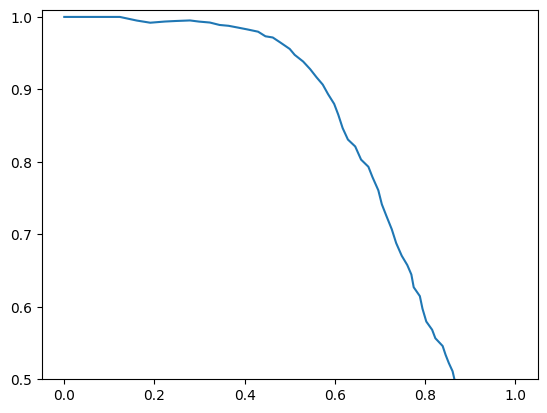

0.823

In [647]:
draw_avg_roc_curve(randforest, "random forest", X, y)

In [738]:
for k, v in model_scores.items():
    # print(v)
    # print(v.keys())
    print(k, v['test_neg_log_loss'])
    # print(k, v['test_neg_brier_score'])


knn -5.425432062692812
ensemble -0.1691985513793655
random forest -0.3462185093591893
mlp -0.28408451761586806
xgb -0.21983037778213302


In [214]:
# print(em.meta_classifier)
pickle.dump(cv, open('em-score.pkl', 'wb'))

In [277]:
pickle.dump(em, open('models/curr_models/em-f2-4.pkl', 'wb'))

In [270]:
# knn researchers
ds = dataset['f3-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# knn
knn = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=1, n_jobs=-1), n_estimators=1, n_jobs=-1)
knn.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=-1,
                                                              n_neighbors=1),
                          n_estimators=1, n_jobs=-1)

Area Under Curve: 0.87
0.9078080903104422
0.8713127341196036
0.8417091509236267
0.7193995318130674
[0.14393227 0.52272727 1.        ]
[1.         0.90196078 0.        ]


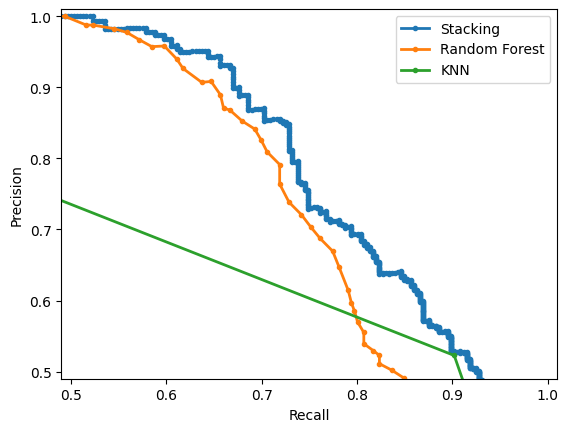

In [276]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

precision, recall, thresholds = precision_recall_curve(y_test, em.predict_proba(X_test)[:,1])
area = auc(recall, precision)

print('Area Under Curve: %.2f' % area)

print(accuracy_score(y_test, em.predict(X_test)))

# print(average_precision_score(y_test, em.predict_proba(X_test)[:,1]))

# plot precision-recall curve
plt.plot(recall, precision, marker='.', label='Stacking', linewidth=2)

# get precision recall curve
# plot the precision-recall curves
print(auc(recall, precision))

no_skill = len(y_test[y_test==1]) / len(y_test)
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', linewidth=2)

# precision, recall, thresholds = precision_recall_curve(y_test, xgb1.predict_proba(X_test)[:, 1])
# plt.plot(recall, precision, marker='.', label='XGBoost')


# plot precision recall for knn
precision, recall, thresholds = precision_recall_curve(y_test, randforest.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.', label='Random Forest', linewidth=2)
print(auc(recall, precision))

# precision, recall, thresholds = precision_recall_curve(y_test, mlp.predict_proba(X_test)[:, 1])
# plt.plot(recall, precision, marker='.', label='MLP', linewidth=2)
# print(auc(recall, precision))
ds = dataset['f3-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

precision, recall, thresholds = precision_recall_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.xlim([0.49, 1.01])
plt.ylim([0.49, 1.01])
plt.plot(recall, precision, marker='.', label='KNN', linewidth=2)
print(auc(recall, precision))

print(precision)
print(recall)

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

Area Under Curve: 0.87
0.9078080903104422
0.8713127341196036
0.8417091509236267
0.7193995318130674
[0.14393227 0.52272727 1.        ]
[1.         0.90196078 0.        ]


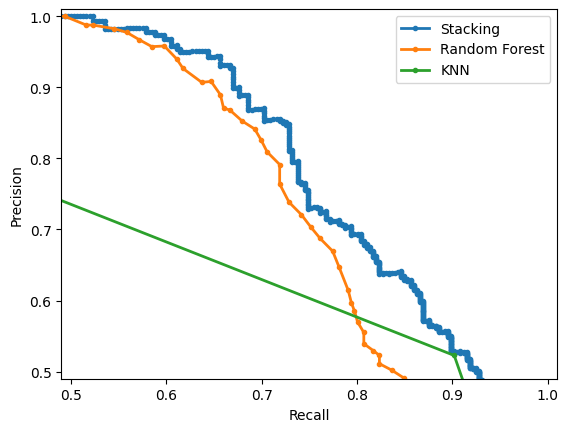

In [278]:
# knn, random forest, xgboost, mlp, svm, gradient boosting classifier, logistic regression
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

precision, recall, thresholds = precision_recall_curve(y_test, em.predict_proba(X_test)[:,1])
area = auc(recall, precision)

print('Area Under Curve: %.2f' % area)

print(accuracy_score(y_test, em.predict(X_test)))

# pickle.dump(em, open('models/curr_models/custom-ensemble-f2-4.pkl', 'wb'))
# print(average_precision_score(y_test, em.predict_proba(X_test)[:,1]))

# plot precision-recall curve
plt.plot(recall, precision, marker='.', label='Stacking', linewidth=2)

# get precision recall curve
# plot the precision-recall curves
print(auc(recall, precision))

# no_skill = len(y_test[y_test==1]) / len(y_test)

# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', linewidth=2)

# precision, recall, thresholds = precision_recall_curve(y_test, xgb1.predict_proba(X_test)[:, 1])
# plt.plot(recall, precision, marker='.', label='XGBoost')


# plot precision recall for knn
precision, recall, thresholds = precision_recall_curve(y_test, randforest.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.', label='Random Forest', linewidth=2)
print(auc(recall, precision))

# precision, recall, thresholds = precision_recall_curve(y_test, mlp.predict_proba(X_test)[:, 1])
# plt.plot(recall, precision, marker='.', label='MLP', linewidth=2)
# print(auc(recall, precision))
ds = dataset['f3-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

precision, recall, thresholds = precision_recall_curve(y_test, knn.predict_proba(X_test)[:, 1])
plt.xlim([0.49, 1.01])
plt.ylim([0.49, 1.01])
plt.plot(recall, precision, marker='.', label='KNN', linewidth=2)
print(auc(recall, precision))

print(precision)
print(recall)

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

roc: 0.9610769949005245
roc: 0.9457273935215111
roc: 0.8817496229260935


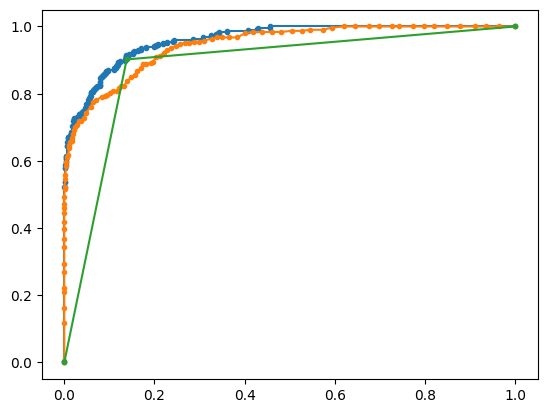

In [289]:
ds = dataset['f2-4']
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# AUC
fpr, tpr, _ = roc_curve(y_test, em.predict_proba(X_test)[:,1])
auc_thing = roc_auc_score(y_test, em.predict_proba(X_test)[:,1])
print("roc: " + str(auc_thing))
plt.plot(fpr,tpr, marker='.', label='Stacking')

# AUC
fpr, tpr, _ = roc_curve(y_test, randforest.predict_proba(X_test)[:,1])
auc_thing = roc_auc_score(y_test, randforest.predict_proba(X_test)[:,1])
print("roc: " + str(auc_thing))
plt.plot(fpr,tpr, marker='.', label='Random Forest')

# AUC
# fpr, tpr, _ = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
# auc_thing = roc_auc_score(y_test, mlp.predict_proba(X_test)[:,1])
# print("roc: " + str(auc_thing))
# plt.plot(fpr,tpr, marker='.', label='MLP')

# # AUC
# fpr, tpr, _ = roc_curve(y_test, xgb1.predict_proba(X_test)[:,1])
# auc_thing = roc_auc_score(y_test, xgb1.predict_proba(X_test)[:,1])
# print("roc: " + str(auc_thing))
# plt.plot(fpr,tpr, marker='.', label='XGBoost')

# AUC
ds = dataset['f3-4'] # researchers
X, y = ds['X'], ds['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
auc_thing = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
print("roc: " + str(auc_thing))
plt.plot(fpr,tpr, marker='.', label='KNN')


plt.show()

In [305]:
print(brier_score_loss(y_test, em.predict_proba(X_test)[:,1]))
print(brier_score_loss(y_test, randforest.predict_proba(X_test)[:,1]))
print(brier_score_loss(y_test, knn.predict_proba(X_test)[:,1]))

print(log_loss(y_test, em.predict_proba(X_test)[:,1]))
print(log_loss(y_test, randforest.predict_proba(X_test)[:,1]))
print(log_loss(y_test, knn.predict_proba(X_test)[:,1]))
print(log_loss(y_test, mlp.predict_proba(X_test)[:,1]))
print(log_loss(y_test, xgb1.predict_proba(X_test)[:,1]))


0.09339658777272501
0.18294031044214487
0.13264346190028223
0.3025287017547703
0.5508595524247073
4.581437649067368
0.300889840276235
0.4672679518291966


In [49]:
x = cross_validate(em.meta_clf_, X, y, cv=5, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score', 'average_precision'], verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350:

In [50]:
for k, v in x.items():
    print(k, v.mean())
    # modelScores[name][k]=v.mean()

fit_time 1.0964632987976075
score_time 0.008139228820800782
test_recall 0.4653217332828983
test_f1 0.5366943173652114
test_accuracy 0.8994014719716674
test_precision 0.6966997540133837
test_roc_auc 0.8787708820719597
test_neg_brier_score -0.07558212884947939
test_average_precision 0.674270494108131


In [52]:
z = cross_val_score(em, X, y, cv=5, scoring='average_precision', verbose=1, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting 3 classifiers...
Fitting 3 classifiers...
Fitting classifier1: balancedbaggingclassifier (1/3)Fitting classifier1: balancedbaggingclassifier (1/3)

Fitting 3 classifiers...Fitting 3 classifiers...

Fitting classifier1: balancedbaggingclassifier (1/3)
Fitting classifier1: balancedbaggingclassifier (1/3)
Fitting classifier1: balancedbaggingclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedrandomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedrandomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedrandomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedrandomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedrandomforestclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.2s finished
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

In [56]:
print(z.mean())

0.7747447765328916


In [115]:
print(accuracy_score(y_test, em.predict(X_test)))
print(recall_score(y_test, em.predict(X_test)))
print(f1_score(y_test, em.predict(X_test)))
# pickle.dump(em, open('models/curr_models/ensemble.pkl', 'wb'))
asdf = pickle.load(open('models/curr_models/xgb1-test.pkl', 'rb'))


# print(em.)


0.9388523047977423
0.7352941176470589
0.7758620689655173


In [116]:
print(accuracy_score(y_test, asdf.predict(X_test)))
print(recall_score(y_test, asdf.predict(X_test)))
print(f1_score(y_test, asdf.predict(X_test)))

print(accuracy_score(y_test, temp_svm.predict(X_test)))
print(recall_score(y_test, temp_svm.predict(X_test)))
print(f1_score(y_test, temp_svm.predict(X_test)))

0.967074317968015
0.7973856209150327
0.874551971326165
0.9285042333019755
0.7941176470588235
0.7617554858934168


In [127]:
# print(em.clfs_)
x = cross_val_score(em, X, y, cv=2, scoring='recall', verbose=1, n_jobs=-1)
# x = cross_validate(em.clfs_, X, y, cv=2, scoring=['recall', 'f1', 'accuracy', 'precision', 'roc_auc', 'neg_brier_score'], verbose=1, n_jobs=-1)
# name = 'ensemble_lengthdiv_4'
# if (name not in modelScores):
#     modelScores[name] = {}
#     for k, v in x.items():
#         print(k, v.mean())
#         modelScores[name][k]=v.mean()
# else:
#     print('already in modelScores')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 classifiers...
Fitting 3 classifiers...
Fitting classifier1: balancedbaggingclassifier (1/3)
Fitting classifier1: balancedbaggingclassifier (1/3)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedbaggingclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier2: balancedbaggingclassifier (2/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


Fitting classifier3: balancedbaggingclassifier (3/3)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.7s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.2min finished


In [128]:
print(x)

[0.77172503 0.71725032]


In [48]:
# dump em
pickle.dump(em, open('models/curr_models/em.pkl', 'wb'))